# Maximize and compare the accuracy of the following extractive summarization models: keyBERT, SciBERTSUM, MemSum

Project work to complete the exam in [Text Mining by Prof. Gianluca Moro in the AC 2022/23 in Bologna](https://www.unibo.it/en/teaching/course-unit-catalogue/course-unit/2022/446610).

The SamSum dataset is given and already divided into train, test and validation. The models have to predict the relevant sentences. This notebook focuses on the results achieved with [MemSum](https://github.com/nianlonggu/memsum) as for the other models there were various problems. `SciBERTSum` was badly documented, for `keyBERT` the time run out when writing the scoring.

The project should be developed in colab with code commented in such a way that every step is understandable even without your verbal explanation in the discussion session.

### Task description

A dataset of social media-like dialoge `SamSum` is given with a ground truth of the sentences and the tokens (of the sentences) most relevant.

The task is now to use different models trained on summarization, adapt them to the dataset given and compare their performance on the tasks of

* extractive summarization

### Metrics

* ROUGE-N for MemSum, keyBERT [see](https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460)

### Multi-step Episodic Markov decision process extractive SUMmarizer (MemSum)

Based on reinforcement-learning episodic Markov decision processes, this extractive summarizer uses at each step

1. the text context of the sentence
2. the global text context (!)
3. and the extraction history (!)

While iteratively selecting further sentences to extract, it also auto-selects the stop state. It produces concise summaries with little redudancy.

Even though that the model is lightweight, it has SOTA performance on long documents from PubMed, arXiv, and GovReport


### Expected results

* MemSum, SciBERTSUM should be very good for long texts
* MemSum should generate short summaries compared to other models, less redundant
* keyBERT should be fast

## Preparation

[Recommendations how to install packages](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/)

In [1]:
# !python3 -m venv env/ # only if you don't have a virtual environment
!source env/bin/activate

In [ ]:
# run the following code only if you are in google colab
!git clone https://github.com/MagnusOstertag/ExtractiveSummaryModels.git

import sys
!cd ExtractiveSummaryModels/ && {sys.executable} -m pip install -r requirements.txt

# set the working directory
import os
os.chdir('/content/ExtractiveSummaryModels/')

# change the path in config.py - /content/ExtractiveSummaryModels/
!sed 's/os.path.dirname(os.path.realpath(__file__))/'\''\/content\/ExtractiveSummaryModels\/'\''/' -i config.py

In [2]:
# run the following code only if you are NOT in google colab
import sys
!{sys.executable} -m pip install -r requirements.txt

# set the working directory
import os
import config
os.chdir(config.ENV_PATH)

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/cu116/torch_stable.html
ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk


In [3]:
import numpy as np
import pandas as pd
import config 
import json
import torch
import logging
import pickle

# optimization
from sklearn.model_selection import ParameterGrid

# utils module
import data_preparation

# parsing
import stanza

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# scoring
from rouge_score import rouge_scorer

In [4]:
# make sure my changes from my models are loaded
%load_ext autoreload
%autoreload 2

import importlib

## Computing some summary statistics about the dataset

In [5]:
# visualize the data
path_to_metadata = os.path.join(config.DATA_PATH, 'metadata.csv')
if not os.path.isfile(path_to_metadata):
    data_preparation.computing_metadata(path_to_metadata)
metadata = pd.read_csv(path_to_metadata)


The `dialog_prolems.log`-file generated while computing the metadata shows that for a number of dialogues there are no finegraned keywords available. Therefore, later we will choose to exclude those when generating the data later on.

In [6]:
metadata[metadata['n_tokens_per_extract_fine'] == 0.]

,name,n_dialogues,n_sentences_dialogue,n_tokens_dialogue,n_tokens_per_sentence,n_tokens_max_per_sentence_dialoguen_extracts_per_summary_rel,n_tokens_per_extract_rel,n_tokens_min_per_extract_rel,n_tokens_max_per_extract_rel,n_extracts_per_summary_fine,n_tokens_per_extract_fine,n_tokens_min_per_extract_fine,n_tokens_max_per_extract_fine,n_tokens_max_per_sentence_dialogue,n_extracts_per_summary_rel
159,test,819,7,63,9.000000,NaN,10.500000,3,17,0,0.0,1.0,3.0,17.0,6.0
177,test,819,4,46,11.500000,NaN,9.200000,2,15,0,0.0,7.0,7.0,22.0,5.0
547,test,819,2,17,8.500000,NaN,5.666667,4,8,0,0.0,3.0,3.0,9.0,3.0
684,test,819,4,43,10.750000,NaN,7.166667,5,9,0,0.0,1.0,11.0,16.0,6.0
745,test,819,23,222,9.652174,NaN,40.000000,3,21,0,0.0,4.0,4.0,27.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15924,val,818,4,45,11.250000,NaN,11.000000,11,11,0,0.0,2.0,4.0,14.0,1.0
15929,val,818,3,25,8.333333,NaN,6.250000,3,6,0,0.0,2.0,8.0,12.0,4.0
16022,val,818,3,62,20.666667,NaN,10.333333,3,12,0,0.0,1.0,17.0,27.0,6.0
16131,val,818,8,58,7.250000,NaN,8.285714,2,11,0,0.0,2.0,2.0,17.0,7.0


In [7]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16366 entries, 0 to 16365
Data columns (total 15 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   name                                                          16366 non-null  object 
 1   n_dialogues                                                   16366 non-null  int64  
 2   n_sentences_dialogue                                          16366 non-null  int64  
 3   n_tokens_dialogue                                             16366 non-null  int64  
 4   n_tokens_per_sentence                                         16366 non-null  float64
 5   n_tokens_max_per_sentence_dialoguen_extracts_per_summary_rel  0 non-null      float64
 6   n_tokens_per_extract_rel                                      16366 non-null  float64
 7   n_tokens_min_per_extract_rel                                  16366

For the `memsum`-model we need to know certain things about our dataset to set the parameters correctly (`memsum` expects them as int):

* max_seq_len: longer sentences are truncated or for shorter sentences `pad` tokens are added (see appendix F), we might overestimate the number of tokens here as there are many fill-in and positional tokens in the dataset
* max_doc_len: longer documents are truncated or for shorter documents empty-string sentences are added (see appendix F)
* max_extracted_sentences_per_document

And further we need to know some things about the machine:

* n_device: whether there is a GPU and if yes how many
* batch_size_per_device

In [8]:
# memsum
print("\nMEMSUM\n")
print(f"The maximum number of tokens per dialog in the training set is {metadata[metadata['name'] == 'train']['n_tokens_max_per_sentence_dialogue'].max()}")
print(f"The maximum number of tokens per dialog in the validation set is {metadata[metadata['name'] == 'val']['n_tokens_max_per_sentence_dialogue'].max()}")
print(f"The maximum number of tokens per dialog in the test set is {metadata[metadata['name'] == 'test']['n_tokens_max_per_sentence_dialogue'].max()}")
max_seq_len = int(metadata['n_tokens_max_per_sentence_dialogue'].max())
print("------------------------------------")

print(f"The maximum number of sentences per dialog in the training set is {metadata[metadata['name'] == 'train']['n_sentences_dialogue'].max()}")
print(f"The maximum number of sentences per dialog in the validation set is {metadata[metadata['name'] == 'val']['n_sentences_dialogue'].max()}")
print(f"The maximum number of sentences per dialog in the test set is {metadata[metadata['name'] == 'test']['n_sentences_dialogue'].max()}")
max_doc_len = int(metadata['n_sentences_dialogue'].max())
print("------------------------------------")

print(f"The maximum number of separate keywords per document in the training set is {metadata[metadata['name'] == 'train']['n_extracts_per_summary_rel'].max()}")
print(f"The maximum number of separate keywords per document in the validation set is {metadata[metadata['name'] == 'val']['n_extracts_per_summary_rel'].max()}")
print(f"The maximum number of separate keywords per document in the test set is {metadata[metadata['name'] == 'test']['n_extracts_per_summary_rel'].max()}")
max_extracted_sentences_per_document = int(metadata['n_extracts_per_summary_rel'].max())
print("------------------------------------")

# keybert
print("\nKEYBERT\n")
print(f"The number of tokens in the summary in the training set is between {metadata[metadata['name'] == 'train']['n_tokens_min_per_extract_rel'].min()} and {metadata[metadata['name'] == 'train']['n_tokens_max_per_extract_rel'].max()}")
print(f"The number of tokens in the summary in the validation set is between {metadata[metadata['name'] == 'val']['n_tokens_min_per_extract_rel'].min()} and {metadata[metadata['name'] == 'val']['n_tokens_max_per_extract_rel'].max()}")
print(f"The number of tokens in the summary in the test set is between {metadata[metadata['name'] == 'test']['n_tokens_min_per_extract_rel'].min()} and {metadata[metadata['name'] == 'test']['n_tokens_max_per_extract_rel'].max()}")
min_n_tokens_per_extract_rel = int(metadata['n_tokens_min_per_extract_rel'].min())
max_n_tokens_per_extract_rel = int(metadata['n_tokens_max_per_extract_rel'].max())
print("------------------------------------")

print(f"The number of tokens in the refined summary in the training set is between {metadata[metadata['name'] == 'train']['n_tokens_min_per_extract_fine'].min()} and {metadata[metadata['name'] == 'train']['n_tokens_max_per_extract_fine'].max()}")
print(f"The number of tokens in the refined summary in the validation set is between {metadata[metadata['name'] == 'val']['n_tokens_min_per_extract_fine'].min()} and {metadata[metadata['name'] == 'val']['n_tokens_max_per_extract_fine'].max()}")
print(f"The number of tokens in the refined summary in the test set is between {metadata[metadata['name'] == 'test']['n_tokens_min_per_extract_fine'].min()} and {metadata[metadata['name'] == 'test']['n_tokens_max_per_extract_fine'].max()}")
min_n_tokens_per_extract_fine = int(metadata['n_tokens_min_per_extract_fine'].min())
max_n_tokens_per_extract_fine = int(metadata['n_tokens_max_per_extract_fine'].max())
print("------------------------------------")

# available GPU devices
print("\nMACHINE\n")
n_device = None
if torch.cuda.is_available():
    print('GPU available!')
    print(f"Total number of available devices: {torch.cuda.device_count()}")
    device = torch.device(0)
    n_device = torch.cuda.device_count()
else:
    print('GPU not available.')
    device = torch.device('cpu')
    n_device = 0
    raise Exception("No GPU available, MemSum won't train!")  # TOCHANGE

batch_size_per_device = 1 # maximum my device supports, for 2 it dies after 5it


MEMSUM

The maximum number of tokens per dialog in the training set is 294.0
The maximum number of tokens per dialog in the validation set is 171.0
The maximum number of tokens per dialog in the test set is 209.0
------------------------------------
The maximum number of sentences per dialog in the training set is 98
The maximum number of sentences per dialog in the validation set is 72
The maximum number of sentences per dialog in the test set is 78
------------------------------------
The maximum number of separate keywords per document in the training set is 30.0
The maximum number of separate keywords per document in the validation set is 24.0
The maximum number of separate keywords per document in the test set is 23.0
------------------------------------

KEYBERT

The number of tokens in the summary in the training set is between 1 and 96
The number of tokens in the summary in the validation set is between 1 and 90
The number of tokens in the summary in the test set is between 1 

/home/work/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


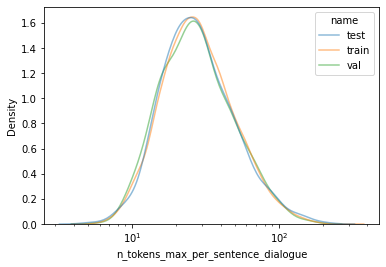

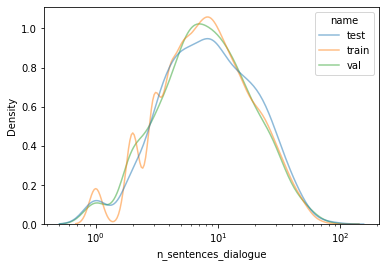

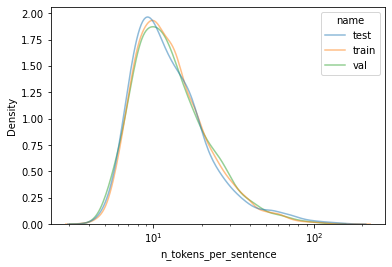

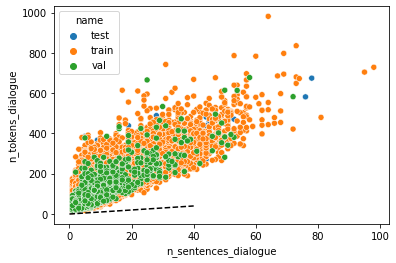

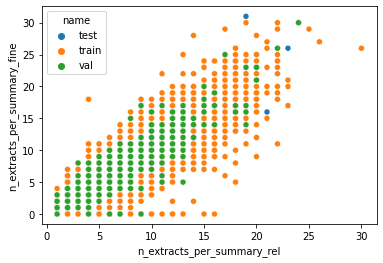

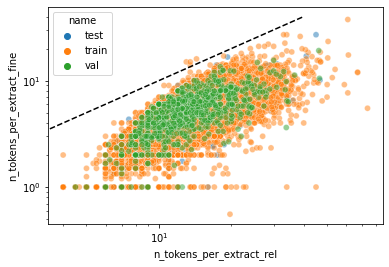

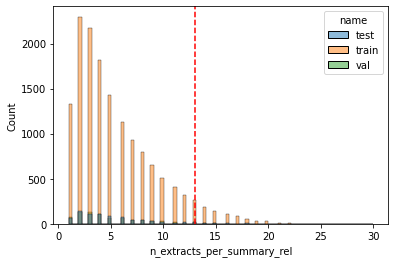

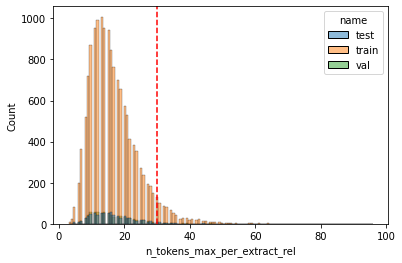

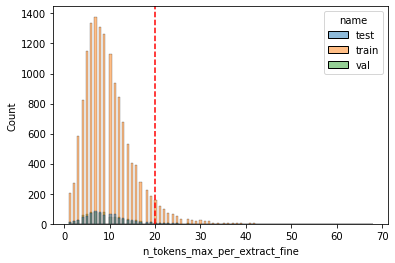

In [9]:
sns.kdeplot(data=metadata, x='n_tokens_max_per_sentence_dialogue', hue='name',
            log_scale=True, common_norm=False, alpha=0.5)
plt.show()
sns.kdeplot(data=metadata, x='n_sentences_dialogue', hue='name', 
            log_scale=True, common_norm=False, alpha=0.5)
plt.show()
sns.kdeplot(data=metadata, x='n_tokens_per_sentence', hue='name',
            log_scale=True, common_norm=False, alpha=0.5)
plt.show()

sns.scatterplot(data=metadata, x='n_sentences_dialogue', y='n_tokens_dialogue', hue='name')
plt.plot([0, 40], [0, 40], color='black', linestyle='--')
plt.show()
sns.scatterplot(data=metadata, x='n_extracts_per_summary_rel', y='n_extracts_per_summary_fine', hue='name')
plt.show()
sns.scatterplot(data=metadata, x='n_tokens_per_extract_rel', y='n_tokens_per_extract_fine', hue='name',
                alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.plot([0, 40], [0, 40], color='black', linestyle='--')
# plot a line parallel to the x-axis # TODO, does not work...
# plt.axyline(x=0)
plt.show()

sns.histplot(data=metadata, x='n_extracts_per_summary_rel', hue='name', common_norm=False, alpha=0.5)
plt.axvline(metadata[metadata['name'] == 'train']['n_extracts_per_summary_rel'].quantile(0.95), color='red', linestyle='--')
plt.show()

sns.histplot(data=metadata, x='n_tokens_max_per_extract_rel', hue='name', common_norm=False, alpha=0.5)
plt.axvline(metadata[metadata['name'] == 'train']['n_tokens_max_per_extract_rel'].quantile(0.95), color='red', linestyle='--')
plt.show()

sns.histplot(data=metadata, x='n_tokens_max_per_extract_fine', hue='name', common_norm=False, alpha=0.5)
plt.axvline(metadata[metadata['name'] == 'train']['n_tokens_max_per_extract_fine'].quantile(0.95), color='red', linestyle='--')
plt.show()

The train, val and test split seems to work quiet well and the data is well represented in all three classes. We'll use the `95th` percentile value (of the training data) later on to set an appropriate n-gram value.

## MemSum

In the `memsum_model.py` script the heavy lifting is done following [this example](https://github.com/nianlonggu/MemSum/blob/main/Data_processing_training_and_testing_for_MemSum.ipynb):

* `prepare_memsum()`: download the pretrained word embeddings
* `prepare_data()`: store the data in the right way in `.jsonl` files, get the `high-ROUGE` episodes for the training set
* `train_memsum()`: train a memsum-model with given hyperparameter
* `evaluate_memsum()`: evaluates the memsum-model on a test/val dataset

`prepare_memsum()` and `train_memsum()` exist also in this notebook as various shell commands would not work otherwise (especially in colab without subprocesses).

In the following for both the sentence and the keyword task the optimal set of hyperparameters is found.

In next code cell are all hyperparameters of the memsum model, the first value for the model parameters is the default value. I chose to explore specifically the following hyperparameters:

* learning rate: for ML models this is often the most important parameter
* p stop thres: for the memsum-model this is a very important parameter, in appendix D they show that the value could be optimal in the range from $0.5 - 0.8$ for different `ROUGE` scores and different datasets
* dropout rate: an important parameter for the NN
* hidden dimensions: The model might even be a bit easier than on the other corpus

In [ ]:
# hyperparameters to try
hyperparams_to_try_memsum = ParameterGrid({# the model parameters
                                            'hidden_dim': [1024, 512],
                                            'N_enc_l': [3],
                                            'N_enc_g': [3],
                                            'N_dec': [3],
                                            'num_of_epochs': [50],
                                            'validate_every': [1000],
                                            'learning_rate': [1e-4],
                                            'warmup_step': [1000],
                                            'weight_decay': [1e-6],
                                            'dropout_rate': [0.1, 0.2],
                                            # 'moving_average_decay': [0.999], # no default given
                                            'p_stop_thres': [0.7, 0.6, 0.5, 0.8],
                                            'apply_length_normalization': [1],
                                            # the following parameters are chosen based on the statistics calculated above
                                            'max_seq_len': [max_seq_len],  # default 100
                                            'max_doc_len': [max_doc_len],  # default 500
                                            'max_extracted_sentences_per_document': [max_extracted_sentences_per_document],  # default 7
                                            # the following parameters are chosen based on user conveniance and machine performance
                                            'num_heads': [4],  # default 8
                                            'print_every': [100],
                                            'save_every': [500],
                                            'restore_old_checkpoint': [True],
                                            'n_device': [n_device],
                                            'batch_size_per_device': [batch_size_per_device],})

In [ ]:
import memsum_model
memsum_model.prepare_memsum()
os.chdir(os.path.join(config.ENV_PATH,'MemSum-015ddda'))

The pretrained word embeddings are already downloaded, not retrieving glove.
Archive:  stanford-corenlp-latest.zip


E: Unsupported file /dev/null given on commandline
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
File ‘stanford-corenlp-latest.zip’ already there; not retrieving.



In [ ]:
def prepare_memsum():
    # prepare MemSum folder etc. here as the subprocesses won't work
    ! mkdir -p "MemSum-015ddda/model" && cd "MemSum-015ddda/model" && gdown "https://drive.google.com/drive/folders/1lrwYrrM3h0-9fwWCOmpRkydvmF6hmvmW" --folder
    ! apt-get install openjdk-8-jdk-headless -qq > /dev/null
    ! wget -nc https://nlp.stanford.edu/software/stanford-corenlp-latest.zip
    ! unzip -n stanford-corenlp-latest.zip
    ! mkdir -p "MemSum-015ddda/data"

    # download the trained memsum models
    if not os.path.exists("MemSum-015ddda/model/run"):
        !mkdir -p "MemSum-015ddda/model/run"
        !cd "MemSum-015ddda/model/run" && gdown "https://drive.google.com/drive/folders/1ckM88u_uyLBRvPoLBxUhiz7rl_Jg3nvt" --folder  # without the parent folder as before

In [ ]:
def train_memsum(run_uid,
                 tokens=False,
                 hidden_dim=1024, N_enc_l=3, N_enc_g=3, N_dec=3, 
                 num_of_epochs=50, validate_every=1000, 
                 learning_rate=1e-4, warmup_step=1000, weight_decay=1e-6, dropout_rate=0.1, 
                 moving_average_decay=0.999, p_stop_thres=0.7, apply_length_normalization=1, 
                 max_seq_len=100, max_doc_len=500, max_extracted_sentences_per_document=7,
                 num_heads=8, print_every=100, save_every=500, restore_old_checkpoint=True,
                 n_device=8, batch_size_per_device=16):
    """
    Train MemSum on the given data. I have to put the method here as the subprocesses in `memsum_model.py` did not work."""
    os.chdir(os.path.join(config.ENV_PATH,'MemSum-015ddda'))
    print("Started training MemSum")

    # paths to data
    memsum_src_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/src/MemSum_Full')
    memsum_training_corpus_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.DATA_PATH,
                                               f"memsum_{'tokens' if tokens else 'sentences'}_train_labelled.jsonl")
    memsum_trainval_labelled_corpus_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.DATA_PATH,
                                                        f"memsum_{'tokens' if tokens else 'sentences'}_trainval_labelled.jsonl")
    memsum_val_corpus_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.DATA_PATH,
                                          f"memsum_{'tokens' if tokens else 'sentences'}_val.jsonl")

    # model and log folder
    run_uid = run_uid
    model_folder_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.MODEL_PATH, 'run/', f"{run_uid}/")
    log_folder_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.MODEL_PATH, 'run/', f"{run_uid}/", "log/")

    if not os.path.isdir(model_folder_path) or not os.path.isdir(log_folder_path):
        os.makedirs(model_folder_path)
        os.makedirs(log_folder_path)
    else:
        print(f"Model folder {model_folder_path} or log folder {log_folder_path} already exists. Restoring from checkpoint.")
    
    # run training, params in order of the parsing in train.py
    try:
        ! cd $memsum_src_path && python3 train.py -training_corpus_file_name $memsum_training_corpus_path -validation_corpus_file_name $memsum_trainval_labelled_corpus_path -model_folder $model_folder_path -log_folder $log_folder_path -vocabulary_file_name ../../model/glove/vocabulary_200dim.pkl -pretrained_unigram_embeddings_file_name ../../model/glove/unigram_embeddings_200dim.pkl -num_heads $num_heads -hidden_dim $hidden_dim -N_enc_l $N_enc_l -N_enc_g $N_enc_g -N_dec $N_dec -max_seq_len $max_seq_len -max_doc_len $max_doc_len -num_of_epochs $num_of_epochs -print_every $print_every -save_every $save_every -validate_every $validate_every -restore_old_checkpoint $restore_old_checkpoint -learning_rate $learning_rate -warmup_step $warmup_step -weight_decay $weight_decay -dropout_rate $dropout_rate -n_device $n_device -batch_size_per_device $batch_size_per_device -max_extracted_sentences_per_document $max_extracted_sentences_per_document -moving_average_decay $moving_average_decay -p_stop_thres $p_stop_thres -apply_length_normalization $apply_length_normalization
    except:
        print("Training MemSum failed.")
        return "", np.array([np.nan, np.nan, np.nan])

    # evaluate the model
    rouge_score = memsum_model.evaluate_memsum(model_folder_path, memsum_val_corpus_path,
                                                hidden_dim, N_enc_l, N_enc_g, N_dec, p_stop_thres, 
                                                max_seq_len, max_doc_len, max_extracted_sentences_per_document,
                                                num_heads,)
    
    return model_folder_path, rouge_score

### Extract sentences

In [10]:
tokens = False

_ = memsum_model.prepare_data(tokens=tokens)

# check that everything worked correctly
## training data
train_corpus = [ json.loads(line) for line in open("data/memsum_sentences_train.jsonl") ]
print(f"For the train corpus of length {len(train_corpus)} we have the keys {train_corpus[0].keys()}")
print(train_corpus[0]["text"][:3])
print(train_corpus[0]["summary"][:3])
print("-----------------------------------\n")

## high-ROUGE episodes
train_corpus_labelled = [ json.loads(line) for line in open("data/memsum_sentences_train_labelled.jsonl") ]
print(f"For the labelled train corpus of length {len(train_corpus_labelled)} we have the keys {train_corpus_labelled[0].keys()}")
print(train_corpus_labelled[0]["text"][:3])
print(train_corpus_labelled[0]["summary"][:3])
print(train_corpus_labelled[0]["indices"][:3])
print(train_corpus_labelled[0]["score"][:3])
print("-----------------------------------\n")

NameError: name 'memsum_model' is not defined

Now we can train the model for different hyperparameters and score which model was best. There is code such that I can interrupt the models. Training one model took up to `10h`, so I was not able to train as many models as I wanted.

In [ ]:
# import memsum_model; memsum_model = importlib.reload(memsum_model)

run_uid_offset = 1 # TOCHANGE

hyperparameter_set_columns_memsum = list(hyperparams_to_try_memsum[0].keys())
columns_results_memsum = ['tokens',
                        'model_folder_path',
                        'score_val_rouge1','score_val_rouge2','score_val_rougeLsum',
                        'score_test_rouge1','score_test_rouge2','score_test_rougeLsum',]
columns_results_memsum += hyperparameter_set_columns_memsum
results_path_memsum = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.MODEL_PATH, 'run/', f"results.csv")

results_memsum = pd.DataFrame(columns=columns_results_memsum)
results_memsum.to_csv(results_path_memsum)

for run_uid, hyperparameter_set in enumerate(hyperparams_to_try_memsum):
    if run_uid <= run_uid_offset:
        continue
    # run_uid += 1  # TOCHANGE
    # old_model_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda', config.MODEL_PATH, 'run/')  # TOCHANGE
    # ! rm -r $old_model_path
    # print(run_uid, hyperparameter_set)
    # write set of hyperparameters to file
    with open(os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.MODEL_PATH, f"run/{run_uid}/hyperparameters.json"), 'w') as f:
        json.dump(hyperparameter_set, f)

    model_folder_path, score = train_memsum(run_uid,
                                            tokens=tokens,
                                            **hyperparameter_set)

    # append results
    results_memsum.loc[run_uid] = pd.Series({'tokens': tokens,
                                            'model_folder_path': model_folder_path,
                                            'score_val_rouge1': score[0],
                                            'score_val_rouge2': score[1],
                                            'score_val_rougeLsum': score[2],
                                            **hyperparameter_set,})

    # save results
    results_memsum.to_csv(results_path_memsum, header=True)

# get the best model
# best_model_idx = np.argmax(scores_list)
# best_model_path = model_folder_path_list[best_model_idx]
# best_hyperparams = hyperparams_to_try[best_model_idx]
# print(f"The best model is {best_model_idx} with the hyperparameters {best_hyperparams} and the score {scores_list[best_model_idx]}")

Started training MemSum
Model folder /home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/Text_mining/project/ExtractiveSummaryModels/MemSum-015ddda/model/run/2/ or log folder /home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/Text_mining/project/ExtractiveSummaryModels/MemSum-015ddda/model/run/2/log/ already exists. Restoring from checkpoint.
14729it [00:00, 84581.61it/s]
2945it [00:00, 83363.54it/s]
model restored!
optimizer restored!
current_batch restored!
0it [00:00, ?it/s]train.py:227: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  remaining_mask_np = np.ones_like( doc_mask_np ).astype( np.bool ) | doc_mask_np
train.py:228: DeprecationWarning: `np.bo

  1%|          | 9/819 [00:16<24:03,  1.78s/it]


KeyboardInterrupt: 

After some `24h` I interrupted the training on my laptop, with the best results being what is in the `run/2/` folder. The model was not yet converged. However, I could not go on training all the different combinations I initially planned (the code obviously works) as:

* on a cluster with a large `GPU` it would fail with a `torch.cuda.OutOfMemoryError: CUDA out of memory` error
* on a cluster/on my PC with only a `CPU` the `train loader` fails

## Comparing the best models on the test set

* what is the length of the summaries the models produce?
* for human experts three criteria: non-redundancy, coverage, and overall quality
* model runtimes

This prints the score for the successful run:

In [12]:
best_run = 2
tokens = False

In [15]:
import memsum_model; memsum_model = importlib.reload(memsum_model)

model_folder_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.MODEL_PATH, 'run/', f"{best_run}/")
memsum_test_corpus_path = os.path.join(config.ENV_PATH, 'MemSum-015ddda/', config.DATA_PATH,
                                    f"memsum_{'tokens' if tokens else 'sentences'}_test.jsonl")

with open(os.path.join(model_folder_path, 'hyperparameters.json')) as f:
    json_data = json.load(f)

# get subset of dictionary
subset = ['hidden_dim', 'N_enc_l', 'N_enc_g', 'N_dec', 'p_stop_thres', 'max_seq_len', 'max_doc_len', 
          'max_extracted_sentences_per_document', 'num_heads']
hyperparameters = {k: json_data[k] for k in subset}


rouge_score_memsum = memsum_model.evaluate_memsum(model_folder_path, memsum_test_corpus_path,
                                                    **hyperparameters,)
print(f"The rouge_1 score is {rouge_score_memsum[0]:.2f}, the rouge_2 score is {rouge_score_memsum[1]:.2f} and the rouge_Lsum score is {rouge_score_memsum[2]:.2f}.")

100%|██████████| 819/819 [20:51<00:00,  1.53s/it]


array([0.78677851, 0.74020001, 0.78635787])

## Summary and Conclusion

Maybe even human evaluation as in [here](https://github.com/nianlonggu/MemSum/blob/main/MemSum_Human_Evaluation.ipynb)

## Citations

* Nianlong Gu, Elliott Ash, and Richard Hahnloser. 2022. [MemSum: Extractive Summarization of Long Documents Using Multi-Step Episodic Markov Decision Processes.](https://aclanthology.org/2022.acl-long.450) In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 6507–6522, Dublin, Ireland. Association for Computational Linguistics.